(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
@load_pkg ActiveInference
# Import package to revise jlArchetype modules
using Revise

# Import project package
import ActiveInference as AI

# Import basic math
import StatsBase
import Distributions
import Random

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

Random.seed!(42)

Random.TaskLocalRNG()

# Langevin equation numerical integration


## Langevin equation
Our task for this script is to simulate a random walker in 1D that follows
the dynamics of the form
$$
{dx \over dt} = -\gamma x(t) + \xi(t),
$$
where $\gamma$ is the restoration force, and $\xi(t)$ is white noise with
properties
$$
\left\langle \xi(t) \right\rangle = 0,
$$
and
$$
\left\langle \xi(t) \xi(t') \right\rangle = 2D \delta(t-t'),
$$
where $D$ is the diffusion coefficient. We have shown already that the
average position of the random walker is given by
$$
\left\langle x(t) \right\rangle = x_o e^{-\gamma t}.
$$
We also showed that the variance of the position $\sigma^2(x(t))$ is given by
$$
\sigma^2(x(t)) = {D \over \gamma} \left( 1 - e^{-2 \gamma t} \right).
$$
So our task now is to simulate a random walker that follows this stochastic
differential equation and compare the statistics of the trajectories to our
analytical results.

### Numerical implementation of a Langevin equation
Let's now discuss how we are going to numerically simulate these stochastic
dynamics. The way we will work with this is by rewriting the Langevin equation as a discrete difference equation. This is
$$
{x(t + \Delta t) - x(t) \over \Delta t} = -\gamma x(t) + \xi(t).
$$
If we solve for $x(t + \Delta t)$ we find
$$
x(t + \Delta t) = x(t) -\gamma x(t) \Delta t + \xi(t) \Delta t.
$$
With this discrete version of the equation we can simply use Euler's integration method to integrate the equation. What this implies is that given a value for the parameters $\gamma$ and $D$, an initial condition $x_o$ and a time step $\Delta t$ sufficiently small all we have to do is follow the recipe given by this discrete Langevin equation. To include the random step $\xi(t)$ all we have to do is generate a Gaussian pseudo-random number. Let's code a function to perform this numerical integration.





In [2]:
@doc raw"""
    euler_langevin

Numerical integration of the Langevin equation of the form

dx/dt = -γx + ξ.

# Arguments
- `xₒ::Vector{<:Real}` Initial position of walker(s). The number of simulations
  performed is equivalent to the number of initial conditions listed in xo.
- `γ::Real`: Restoration "force" parameter. 
- `D::Real`: Diffusion coefficient.

## Optional keyword arguments
- `Δt::Float64=0.001`. Time step size. 
- `n_steps::Int=500`: Number of steps to use for the integration.

# Returns
- `x::Matrix{Float64}`: Array containing all trajectories.
- `time::Vector{Float64}`: Times where integration was evaluated
"""
function euler_langevin(
    xₒ::Vector{<:Real},
    γ::Real,
    D::Real;
    Δt::Float64=0.001,
    n_steps::Int=500
)
    # Initialize array where to save all trajectories
    x = zeros(length(xₒ), n_steps + 1)
    # Initialize array to save time
    time = zeros(n_steps + 1)

    # Set initial condition
    x[:, 1] = xₒ
    time[1] = 0.0

    # Generate all necessary random numbers before integration
    ξ = Random.rand(Distributions.Normal(0, √(2D * Δt)), length(xₒ), n_steps)

    # Loop through time steps
    for n in 2:n_steps+1
        # Update particle position
        x[:, n] = x[:, n-1] - γ * x[:, n-1] * Δt + ξ[:, n-1]
        # Update time
        time[n] = time[n-1] + Δt
    end # for

    return x, time
end # function


euler_langevin

Let's now test the function.

In [3]:
# Define number of walkers
n_walkers = 100

# Define initial position
xₒ = repeat([2.0], n_walkers)

# Define parameters
γ = 1
D = 1.5
n_steps = 6000

# Run function
x, time = euler_langevin(xₒ, γ, D; n_steps=n_steps)

([2.0 1.9780980910970596 … 0.33722289796786 0.4058534992436244; 2.0 2.011788215153355 … 2.322410276844226 2.3017916917610894; … ; 2.0 2.0181675244575996 … 1.1761292812685666 1.1839393943909524; 2.0 1.9954497522358992 … -0.8875975051371086 -0.8607241652060728], [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  5.991000000000335, 5.992000000000336, 5.993000000000336, 5.994000000000336, 5.995000000000337, 5.996000000000337, 5.997000000000337, 5.998000000000338, 5.999000000000338, 6.000000000000338])

Having generated random trajectories, let's also compute the mean and analytical variance that we expect for these dynamics along with the ones we obtained from the simulations.

In [4]:
# Compute mean trajectory as a function of time
langevin_mean = @. xₒ[1] * exp(-γ * time)

# Compute variance in trajectory
langevin_var = @. D / γ * (1 - exp(-2γ * time))

# Compute trajectories mean
exp_mean = StatsBase.mean(x, dims=1)

# Compute trajectories standard deviation
exp_std = StatsBase.std(x, dims=1)

1×6001 Matrix{Float64}:
 0.0  0.0529749  0.0734513  0.0978399  …  1.301  1.3012  1.30384  1.31229

Let's now look at the trajectories along with a sense for mean $\pm$ standard deviation.

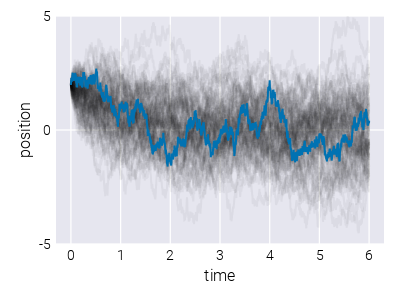

In [5]:
# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time",
    ylabel="position"
)

# Plot trajectories
lines!.(
    ax,
    Ref(time),
    eachrow(x),
    color=(:black, 0.05),
)

# Plot one particular trajectory
lines!(
    ax,
    time,
    x[1, :]
)

ylims!(ax, -5, 5)

fig